# Aim

Make vibrations from an AR2 model of the applied vibration modes, to check consistency.

In [1]:
# imports

import numpy as np
from scipy import optimize, signal, interpolate, stats
import matplotlib.pyplot as plt
import copy
%matplotlib inline

# global parameter definitions

f_sampling = 1000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 10 # number of vibration modes being applied
N_vib_max = 10 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook
time_id = 1 # timescale over which sysid runs. Pulled from Meimon 2010's suggested 1 Hz sysid frequency.

Text(0.5,1,'True vibrations')

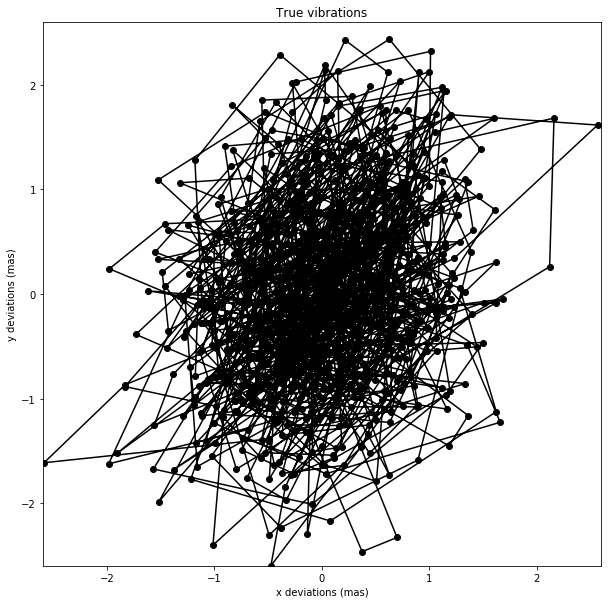

In [2]:
times = np.arange(0, time_id, 1/f_sampling)
vib_freqs = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_amps = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_pa = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_phase = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_damping = np.random.uniform(low=1e-4, high=1e-3, size=N_vib_app) # unitless

# vibrations are vib_amps[i] sin/cos(vib_pa[i]) exp(-vib_damping[i] vib_freqs[i] t) exp(i*(vib_freqs[i] t - vib_phase[i])).

dx = sum([-vib_amps[i]*np.sin(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])
dy = sum([vib_amps[i]*np.cos(vib_pa[i])*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])
          *np.exp(-2*np.pi*vib_damping[i]*vib_freqs[i]*times) for i in range(N_vib_app)])

plt.figure(figsize=(10,10))
plt.plot(dx, dy, 'ko-')
lim = max(np.max(np.abs(dx)), np.max(np.abs(dy)))
plt.xlim((-lim, lim))
plt.ylim((-lim, lim))
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("True vibrations")

Text(0.5,1,'AR2 vibrations')

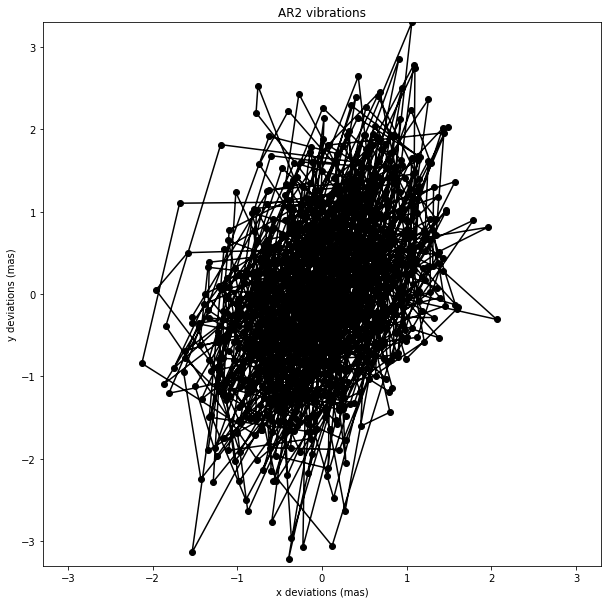

In [3]:
# construct an AR2 model from these vibration modes

STATE_SIZE = 4*N_vib_max # 'N_vib_max' modes each for tip and tilt, and because AR2, those modes one timestep ago.
Q = np.zeros((STATE_SIZE, STATE_SIZE))

A = np.zeros((STATE_SIZE, STATE_SIZE))
for i in range(2*N_vib_max):
    k = vib_damping[i % N_vib_max]
    f = vib_freqs[i % N_vib_max]
    a_1i = 2 * np.exp(-2*k*np.pi*f/f_sampling) * np.cos(2*np.pi*f*np.sqrt(1-k**2)/f_sampling)
    a_2i = -np.exp(-4*k*np.pi*f/f_sampling)
    A[2*i][2*i] = a_1i
    A[2*i][2*i+1] = a_2i
    A[2*i+1][2*i] = 1
    
INPUT_SIZE = 2 # but this is only applied to the measurements
MEASUREMENT_SIZE = 2 # measuring dx, dy

H = np.zeros((MEASUREMENT_SIZE, STATE_SIZE))
for i in np.arange(0, 2*N_vib_max, 2):
    H[0][i] = 1

for i in np.arange(2*N_vib_max, 4*N_vib_max, 2):
    H[1][i] = 1
    
state = np.zeros(STATE_SIZE)
for i in np.arange(0, STATE_SIZE//2, 2):
    state[i] = -vib_amps[i % N_vib_max]*np.sin(vib_pa[i % N_vib_max])*np.sin(-vib_phase[i % N_vib_max])
for i in np.arange(STATE_SIZE//2, STATE_SIZE, 2):
    state[i] = vib_amps[i % N_vib_max]*np.cos(vib_pa[i % N_vib_max])*np.sin(-vib_phase[i % N_vib_max])

# step 8: simulate without filtering and without applying any control input.

dt = 1/f_sampling
t, k = 0, 0
y = np.zeros((time_id * f_sampling, INPUT_SIZE)) # y vector, not physical y.
while k < time_id * f_sampling:
    state = A.dot(state)
    y[k] = H.dot(state)
    k += 1
    t += dt

y = y.T

plt.figure(figsize=(10,10))
lim = np.max(y)
plt.xlim((-lim, lim))
plt.ylim((-lim, lim))
plt.plot(y[0], y[1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("AR2 vibrations")

Text(0.5,1,'Residual')

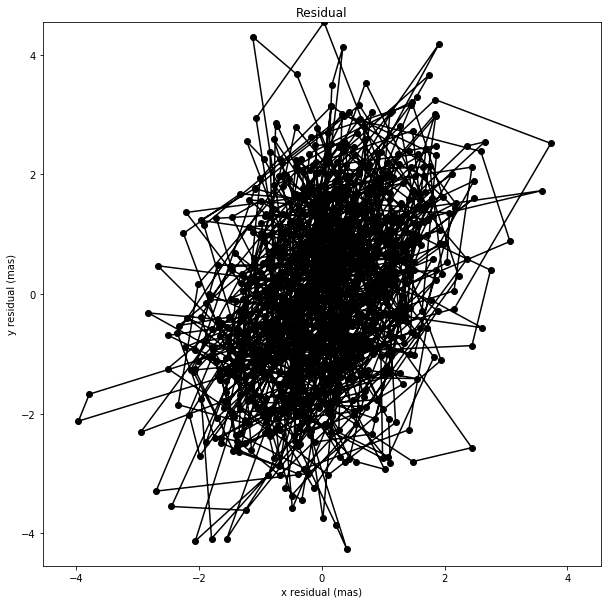

In [4]:
plt.figure(figsize=(10,10))
lim = max(np.max(dx - y[0]), np.max(dy - y[1]))
plt.xlim((-lim, lim))
plt.ylim((-lim, lim))
plt.plot(dx - y[0], dy - y[1], 'ko-')
plt.xlabel("x residual (mas)")
plt.ylabel("y residual (mas)")
plt.title("Residual")